# Image Classification

The goal of this notebook is to have an initial setup for image classification. Basically you only have to change the configurations (like dataset, image specs, etc), and the rest will automatically set.

This notebook is inspired on:
- https://www.tensorflow.org/tutorials/images/classification

Install 3rd party packages

## Setup

### Packages

In [1]:
# tensorflow for apple macbook pro m1 chip
!pip install tensorflow==2.10.0 tensorflow-io==0.27.0

# remaining dependencies
!pip install matplotlib mlflow sklearn

In [2]:
# python core packages
import shutil
import pathlib
import itertools

# 3rd party packages
import PIL
import mlflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Configuration

In [3]:
# where are the images?
data_dir = pathlib.Path('../datasets/image_classification/multiclass/flower_photos')

# how large are the batches?
batch_size = 32

# How long do you want to train?
epochs = 10

# which images dimensions do we want?
img_height = 180
img_width = 180
img_channels = 3

# what seed do you want?
seed = 123

# mlflow
tracking_uri = "http://localhost:5001"
experiment_name = "image_classification"

### Settings

In [4]:
if img_channels == 1:
    color_mode = 'grayscale'
    cmap = 'gray'

if img_channels == 3:
    color_mode = 'rgb'
    cmap = 'viridis'
    
if img_channels == 4:
    color_mode = 'rgba'
    cmap = 'viridis'

## Data

### Training data

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode=color_mode
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


### Validation data

In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode=color_mode
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Class names

In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(f"- Found {num_classes} classes: {class_names}")

- Found 5 classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Class weights

In [8]:
# get the labels (this can take a while, because it has to load ALL images)
y_train = np.concatenate([y for x, y in train_ds], axis=0)

# calculate the weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)

# combine the class_ids with class_weights
class_weights = {class_id:class_weight for class_id, class_weight in zip(range(num_classes), class_weights)}
print(f"The class_weights are: {class_weights}")

The class_weights are: {0: 1.1650793650793652, 1: 0.8132963988919668, 2: 1.127063339731286, 3: 1.073491773308958, 4: 0.9146417445482866}


## Exploratory Data Analysis

### Output directory

In [9]:
graphs_dir = pathlib.Path("../graphs")

# remove the directoy and all its contents 
if graphs_dir.exists():
    shutil.rmtree(graphs_dir, ignore_errors=False, onerror=None)
    
# create the directory
graphs_dir.mkdir(parents=True, exist_ok=True)
    
print(f'Directory cleaned: {graphs_dir}')

Directory cleaned: ../graphs


### Class distribution

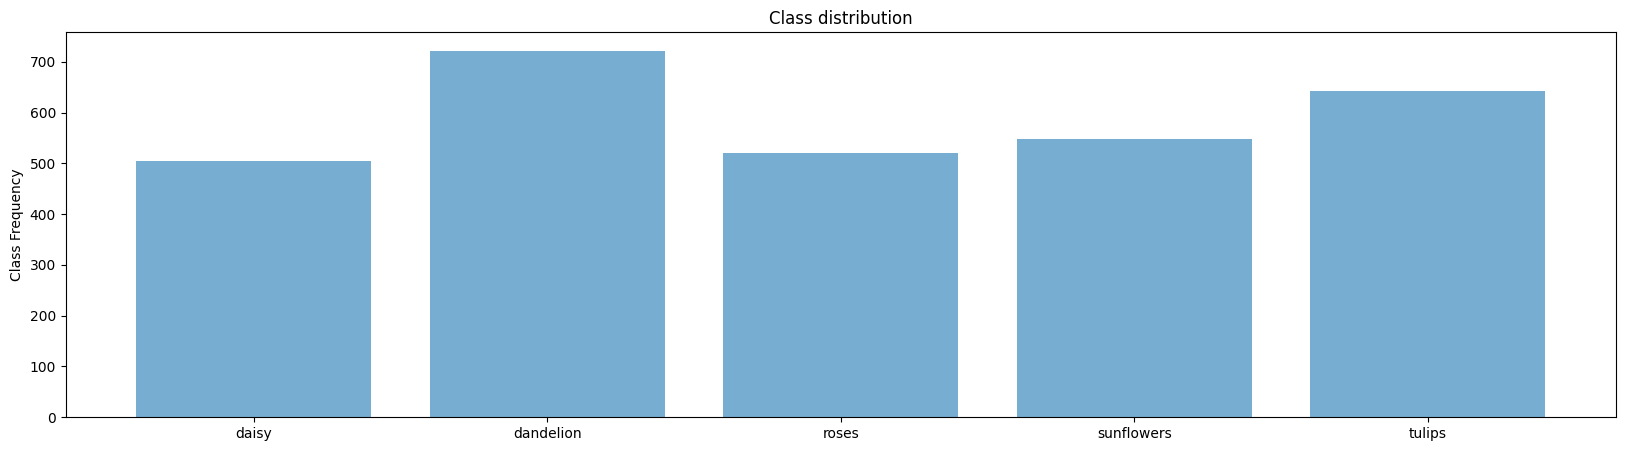

In [10]:
classesIndexes, classesFrequency = np.unique(y_train, return_counts=True)

fig_distribution = plt.figure(figsize=(20, 5))
plt.bar(classesIndexes, classesFrequency, align='center', alpha=0.6)
plt.ylabel('Class Frequency')
plt.xticks(classesIndexes, class_names)
plt.title('Class distribution')
fig_distribution.savefig(graphs_dir / 'class_distribution.png', transparent=True, dpi=500)
plt.show()

### Examples

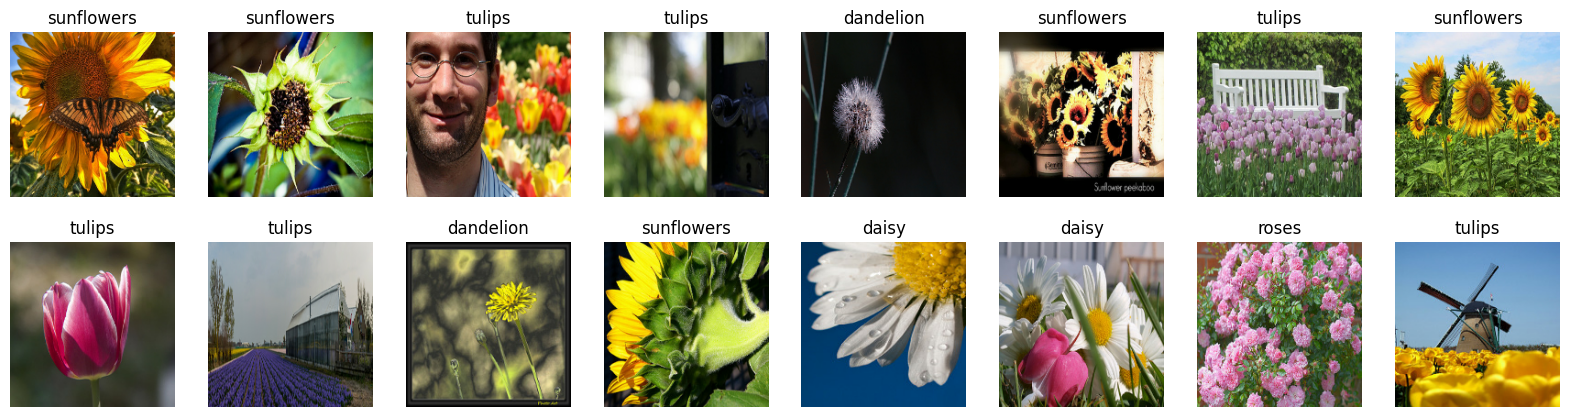

In [11]:
fig_examples = plt.figure(figsize=(20, 5))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(2, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap=cmap)
        plt.title(class_names[labels[i]])
        plt.axis("off")
fig_examples.savefig(graphs_dir / 'examples.png', transparent=True, dpi=500)
plt.show()

### Tensor shape

In [12]:
for image_batch, labels_batch in train_ds:
    print(f"- Image tensor shape:\t(batch, height, width, channels)\t{image_batch.shape}")
    print(f"- Labels tensor shape:\t(batch,)\t\t\t\t{labels_batch.shape}")
    break

- Image tensor shape:	(batch, height, width, channels)	(32, 180, 180, 3)
- Labels tensor shape:	(batch,)				(32,)


### Standardize

In [14]:
first_image = image_batch[0]

print(f"- The image value range: [{np.min(first_image)}, {np.max(first_image)}]")

- The image value range: [0.0, 247.1017303466797]


## Model

### Repository

In [15]:
mlflow.set_experiment(experiment_name)
mlflow.tensorflow.autolog()

experiment = mlflow.get_experiment_by_name(experiment_name)
print(f"mlflow experiment >>> {tracking_uri}/#/experiments/{experiment.experiment_id}")

mlflow experiment >>> http://localhost:5001/#/experiments/1


### Performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Network

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, img_channels)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Training

### Output directory

In [17]:
checkpoints_dir = pathlib.Path("../checkpoints")

# remove the directoy and all its contents 
if checkpoints_dir.exists():
    shutil.rmtree(checkpoints_dir, ignore_errors=False, onerror=None)
    
# create the directory
checkpoints_dir.mkdir(parents=True, exist_ok=True)
    
print(f'Directory cleaned: {checkpoints_dir}')

Directory cleaned: ../checkpoints


### Callbacks

In [18]:
callbacks = [

    # get checkpoints
    tf.keras.callbacks.ModelCheckpoint(
        checkpoints_dir / "save_at_{epoch}.h5"
    ),
    
    # stop when there is no more improvement
#     tf.keras.callbacks.EarlyStopping(
#         monitor="val_loss",
#         min_delta=0,
#         patience=6,
#         mode="auto",
#     ),
    
    # reduce Learning rate when there is no more improvement
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=3,
        mode="auto",
    )
]

### Train

In [20]:
with mlflow.start_run() as run:
    
    # get the run_id
    run_id = run.info.run_id
    print(f"mlflow run >>> {tracking_uri}/#/experiments/{experiment.experiment_id}/runs/{run_id}")
    
    # train the model
    history = model.fit(
        train_ds, 
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks, 
        validation_data=val_ds,
        class_weight=class_weights,
        use_multiprocessing=True,
    )
    
    # upload the checkpoints
    print('Uploading checkpoints')
    mlflow.log_artifacts(checkpoints_dir, artifact_path="checkpoints")

mlflow run >>> http://localhost:5001/#/experiments/1/runs/5dbf2ae9e00f471fa9ae45c4e09c489b
Epoch 1/10
92/92 [==============================] - 16s 176ms/step - loss: 0.0298 - accuracy: 0.9959 - val_loss: 1.5542 - val_accuracy: 0.6444 - lr: 1.0000e-04
Epoch 2/10
92/92 [==============================] - 16s 178ms/step - loss: 0.0249 - accuracy: 0.9966 - val_loss: 1.6361 - val_accuracy: 0.6540 - lr: 1.0000e-04
Epoch 3/10
92/92 [==============================] - 16s 179ms/step - loss: 0.0215 - accuracy: 0.9969 - val_loss: 1.6736 - val_accuracy: 0.6458 - lr: 1.0000e-04
Epoch 4/10
92/92 [==============================] - 17s 180ms/step - loss: 0.0187 - accuracy: 0.9969 - val_loss: 1.7264 - val_accuracy: 0.6458 - lr: 1.0000e-04
Epoch 5/10
92/92 [==============================] - 16s 178ms/step - loss: 0.0162 - accuracy: 0.9973 - val_loss: 1.7283 - val_accuracy: 0.6458 - lr: 1.0000e-05
Epoch 6/10
92/92 [==============================] - 16s 178ms/step - loss: 0.0159 - accuracy: 0.9980 - val_lo

INFO:tensorflow:Assets written to: /tmp/tmpc6f2alb5/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpc6f2alb5/model/data/model/assets


Uploading checkpoints


## Evaluate

### Training history

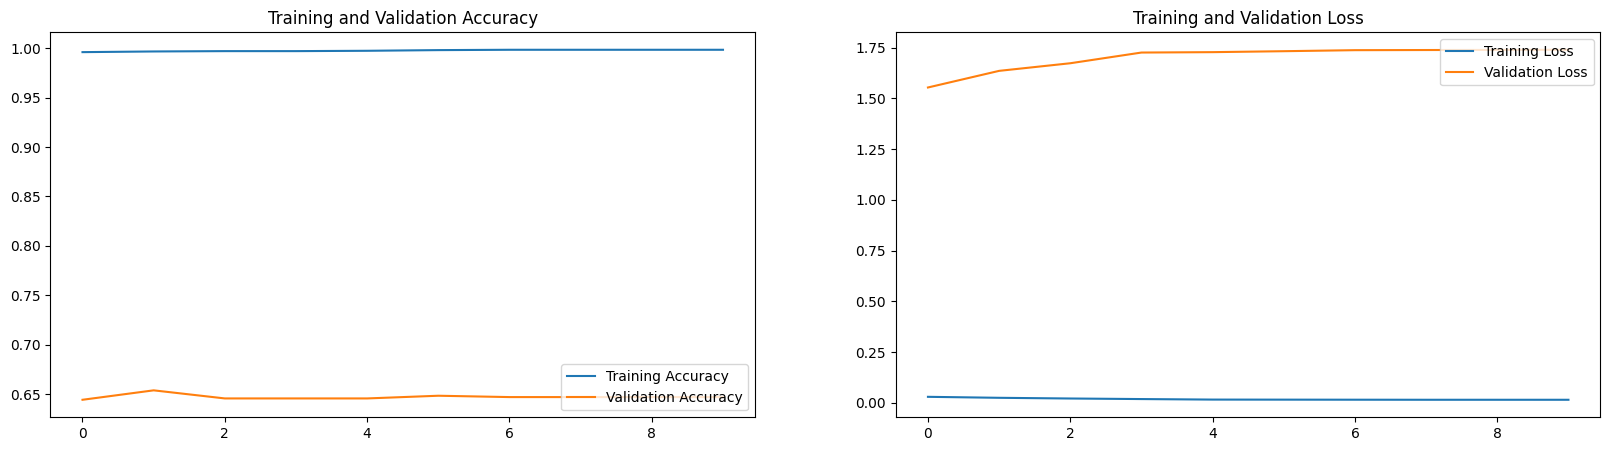

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig_history = plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Confusion matrix

23/23 [==============================] - 1s 52ms/step


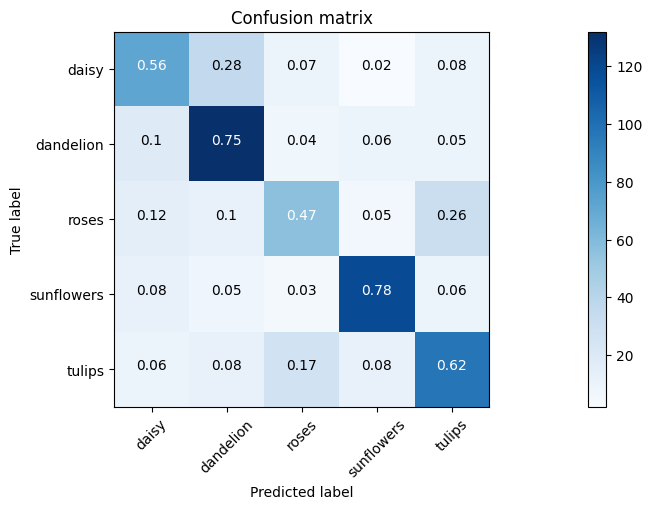

In [22]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """

    fig_cm = plt.figure(figsize=(20, 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
    return fig_cm

# get true Values
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# get predictions
Y_pred = model.predict(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

# get confusion matrix
cm = confusion_matrix(y_true, y_pred)

# generate plot
fig_cm = plot_confusion_matrix(cm, class_names)
plt.show()

### Figures

In [23]:
with mlflow.start_run(run_id=run_id) as run:
    mlflow.log_figure(fig_distribution, "figures/class_distribution.png")
    mlflow.log_figure(fig_examples, "figures/examples.png")
    mlflow.log_figure(fig_history, "figures/training_history.png")
    mlflow.log_figure(fig_cm, "figures/confusion_matrix.png")

### Classification report

In [ ]:
print(classification_report(y_true, y_pred))